<a href="https://colab.research.google.com/github/antaripg/deep-learning-notebooks/blob/main/DRIVE_retinal_vessel_dataset_w_SegNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.
Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [ ]:
from google.colab import drive

drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
%matplotlib inline
import os
import time
import tqdm
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import TensorDataset,DataLoader

print(torch.__version__) # This code has been updated for PyTorch 1.0.0

1.9.0+cu102


In [ ]:
trainPath = '/content/drive/MyDrive/DRIVE_Retinal_dataset/training/'
testPath = '/content/drive/MyDrive/DRIVE_Retinal_dataset/training/'

# trainPath = 'DRIVE/training/'
# testPath = 'DRIVE/test/'



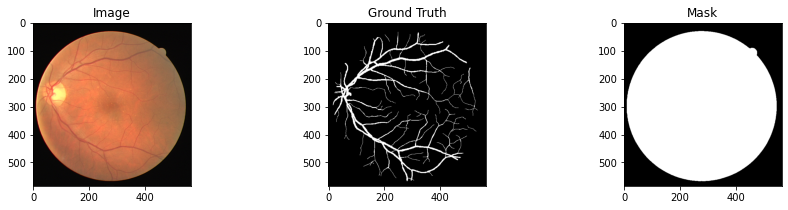

In [ ]:
# Displaying sample image, groundtruth and mask from the dataset
sampleImg = np.array(Image.open(os.path.join(trainPath,'images/21_training.tif')))
sampleGT = np.array(Image.open(os.path.join(trainPath,'1st_manual/21_manual1.gif')))
sampleMask = np.array(Image.open(os.path.join(trainPath,'mask/21_training_mask.gif')))
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.imshow(sampleImg)
plt.title('Image')
plt.subplot(132)
plt.imshow(sampleGT,cmap='gray')
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(sampleMask,cmap='gray')
plt.title('Mask')
plt.show()

In [ ]:
# DRIVE dataset has 20 images for training and 20 for testing
TrainImages = torch.FloatTensor(900,3,224,224) # 15 images x 60 patches
TrainLabels = torch.FloatTensor(900,224,224)
TestImages = torch.FloatTensor(5,3,224,224)
TestLabels = torch.FloatTensor(5,224,224)

# Obtain list containing name of all files in the directoy
trainImgList = os.listdir(os.path.join(trainPath,'images'))
testImgList = os.listdir(os.path.join(testPath, 'images'))

# Preparing train data tensors
img_no = 0
for file in trainImgList[:15]:
    imgNum = file.split('_')[0] # Image number from the filename
    im = Image.open(trainPath+'images/'+ file)
    seg = Image.open(trainPath+'1st_manual/'+str(imgNum)+'_manual1.gif')
    mask = Image.open(trainPath+'mask/'+str(imgNum)+'_training_mask.gif')
    im = np.array(im)
    seg = np.array(seg)/255
    mask = (np.array(mask)/255-seg)
    idx = np.where(mask==1)
    # Note: In the GT (seg), 0--> BG, 1--> Vessels, 2--> Tissue(mask)
    seg[idx] = 2

    # Augmenting training data by taking 60 patches, each of size 224x224, from the original image
    randIdx1 = np.random.randint(0,im.shape[0]-224,60)
    randIdx2 = np.random.randint(0,im.shape[1]-224,60)
    for p in range(60):
        patch = im[randIdx1[p]:randIdx1[p]+224,randIdx2[p]:randIdx2[p]+224,:]/255
        seg_patch = seg[randIdx1[p]:randIdx1[p]+224,randIdx2[p]:randIdx2[p]+224]
        TrainImages[img_no] = torch.from_numpy(patch).transpose(0,2).unsqueeze(0)
        TrainLabels[img_no] = torch.from_numpy(seg_patch).transpose(0,1).unsqueeze(0)
        img_no += 1

# Preparing test data tensors
img_no = 0
for file in testImgList[15:]:
    imgNum = file.split('_')[0] # Image number from the filename
    im = Image.open(trainPath+'images/'+ file)
    seg = Image.open(trainPath+'1st_manual/'+str(imgNum)+'_manual1.gif')
    mask = Image.open(trainPath+'mask/'+str(imgNum)+'_training_mask.gif')
    # Resizing the images to 224x224
    im = np.array(im.resize((224,224)))/255
    seg = np.array(seg.resize((224,224)))/255
    mask = (np.array(mask.resize((224,224)))-seg)/255
    idx = np.where(mask==1)
    # Note: In the GT (seg), 0--> BG, 1--> Vessels, 2--> Tissue(mask)
    seg[idx] = 2
    TestImages[img_no] = torch.from_numpy(im).transpose(0,2).unsqueeze(0)
    TestLabels[img_no] = torch.from_numpy(seg).transpose(0,1).unsqueeze(0)
    img_no += 1

In [ ]:
print(TrainImages.size())
print(TrainLabels.size())
print(TestImages.size())
print(TestLabels.size())

torch.Size([900, 3, 224, 224])
torch.Size([900, 224, 224])
torch.Size([5, 3, 224, 224])
torch.Size([5, 224, 224])


In [ ]:
# Check availability of GPU

use_gpu = torch.cuda.is_available()
# use_gpu = False # Uncomment in case of GPU memory error
if use_gpu:
    print('GPU is available!')
    device = "cuda"
    pin_mem = True
else:
    print('GPU is not available!')
    device = "cpu"
    pin_mem = False
print('Device :'+device)

GPU is not available!
Device :cpu


In [ ]:


# Creating pytorch dataset
trainDataset = TensorDataset(TrainImages, TrainLabels)
testDataset = TensorDataset(TestImages, TestLabels)
# Creating dataloader
BatchSize = 10
trainLoader = DataLoader(trainDataset, batch_size=BatchSize, shuffle=True,num_workers=2, pin_memory=pin_mem)
testLoader = DataLoader(testDataset, batch_size=BatchSize, shuffle=False,num_workers=2, pin_memory=pin_mem)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()

        # Encoder
        self.conv1c = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # Decoder
        self.mup1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv1d = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.relu1(self.conv1c(x))
        x, idx1 = self.mp1(x)
        x = self.mup1(x, idx1)
        x = self.conv1d(x)
        return x

In [ ]:
net = SegNet()
net = net.to(device)

In [ ]:


criterion = nn.NLLLoss() # Negative Log-Likelihood

optimizer = optim.Adam(net.parameters(), lr=1e-3)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/90 [00:00<?, ?it/s]

At Iteration: 1 /15  ;  Training Loss: 0.466793; Time consumed: 1m 45s 
At Iteration: 1 /15  ;  Testing Loss: 1.248020 ; Time consumed: 1m 45s 


  0%|          | 0/90 [00:00<?, ?it/s]

At Iteration: 2 /15  ;  Training Loss: 0.465748; Time consumed: 1m 44s 
At Iteration: 2 /15  ;  Testing Loss: 1.258559 ; Time consumed: 1m 44s 


  0%|          | 0/90 [00:00<?, ?it/s]

At Iteration: 3 /15  ;  Training Loss: 0.463666; Time consumed: 1m 45s 
At Iteration: 3 /15  ;  Testing Loss: 1.270198 ; Time consumed: 1m 45s 


  0%|          | 0/90 [00:00<?, ?it/s]

At Iteration: 4 /15  ;  Training Loss: 0.462399; Time consumed: 1m 44s 
At Iteration: 4 /15  ;  Testing Loss: 1.274367 ; Time consumed: 1m 44s 


  0%|          | 0/90 [00:00<?, ?it/s]

At Iteration: 5 /15  ;  Training Loss: 0.460717; Time consumed: 1m 44s 
At Iteration: 5 /15  ;  Testing Loss: 1.277313 ; Time consumed: 1m 44s 


  0%|          | 0/90 [00:00<?, ?it/s]

At Iteration: 6 /15  ;  Training Loss: 0.458674; Time consumed: 1m 45s 
At Iteration: 6 /15  ;  Testing Loss: 1.288304 ; Time consumed: 1m 45s 


  0%|          | 0/90 [00:00<?, ?it/s]

At Iteration: 7 /15  ;  Training Loss: 0.457678; Time consumed: 1m 43s 
At Iteration: 7 /15  ;  Testing Loss: 1.289713 ; Time consumed: 1m 43s 


  0%|          | 0/90 [00:00<?, ?it/s]

At Iteration: 8 /15  ;  Training Loss: 0.456270; Time consumed: 1m 44s 
At Iteration: 8 /15  ;  Testing Loss: 1.291962 ; Time consumed: 1m 44s 


  0%|          | 0/90 [00:00<?, ?it/s]

At Iteration: 9 /15  ;  Training Loss: 0.456501; Time consumed: 1m 44s 
At Iteration: 9 /15  ;  Testing Loss: 1.288469 ; Time consumed: 1m 44s 


  0%|          | 0/90 [00:00<?, ?it/s]

At Iteration: 10 /15  ;  Training Loss: 0.451918; Time consumed: 1m 46s 
At Iteration: 10 /15  ;  Testing Loss: 1.308477 ; Time consumed: 1m 46s 


  0%|          | 0/90 [00:00<?, ?it/s]

At Iteration: 11 /15  ;  Training Loss: 0.452491; Time consumed: 1m 45s 
At Iteration: 11 /15  ;  Testing Loss: 1.300961 ; Time consumed: 1m 45s 


  0%|          | 0/90 [00:00<?, ?it/s]

At Iteration: 12 /15  ;  Training Loss: 0.449551; Time consumed: 1m 44s 
At Iteration: 12 /15  ;  Testing Loss: 1.296490 ; Time consumed: 1m 44s 


  0%|          | 0/90 [00:00<?, ?it/s]

At Iteration: 13 /15  ;  Training Loss: 0.445840; Time consumed: 1m 44s 
At Iteration: 13 /15  ;  Testing Loss: 1.325787 ; Time consumed: 1m 44s 


  0%|          | 0/90 [00:00<?, ?it/s]

At Iteration: 14 /15  ;  Training Loss: 0.444908; Time consumed: 1m 44s 
At Iteration: 14 /15  ;  Testing Loss: 1.325289 ; Time consumed: 1m 44s 


  0%|          | 0/90 [00:00<?, ?it/s]

At Iteration: 15 /15  ;  Training Loss: 0.441967; Time consumed: 1m 44s 
At Iteration: 15 /15  ;  Testing Loss: 1.328366 ; Time consumed: 1m 44s 
Training completed in 26m 6s


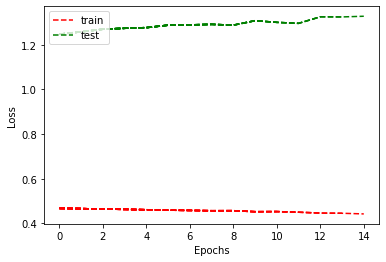

In [ ]:
iterations = 15
trainLoss = []
testLoss = []
start = time.time()

for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0
    net.train() # For training
    for data in tqdm.tqdm_notebook(trainLoader):
        inputs,labels = data
        inputs, labels = inputs.to(device), labels.long().to(device)

        # Feed-forward input data through the network
        outputs = net(inputs)
        # Compute loss/error
        loss = criterion(F.log_softmax(outputs,dim=1), labels)
        # Initialize gradients to zero
        optimizer.zero_grad()
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.item()
    avgTrainLoss = runningLoss/(600.0 /BatchSize)
    trainLoss.append(avgTrainLoss)


    # Evaluating performance on test set for each epoch
    net.eval() # For testing
    test_runningLoss = 0
    with torch.no_grad():
        for data in testLoader:
            inputs,labels = data
            inputs, labels = inputs.to(device), labels.long().to(device)
            outputs = net(inputs)
             # Compute loss/error
            loss = criterion(F.log_softmax(outputs,dim=1), labels)
            # Accumulate loss per batch
            test_runningLoss += loss.item()

    avgTestLoss = test_runningLoss/(20.0/BatchSize)
    testLoss.append(avgTestLoss)

    # Plotting Loss vs Epochs
    fig1 = plt.figure(1)
    plt.plot(range(epoch+1),trainLoss,'r--',label='train')
    plt.plot(range(epoch+1),testLoss,'g--',label='test')
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')


    epochEnd = time.time()-epochStart
    print('At Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f}; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,epochEnd//60,epochEnd%60))
    print('At Iteration: {:.0f} /{:.0f}  ;  Testing Loss: {:.6f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTestLoss,epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))

3


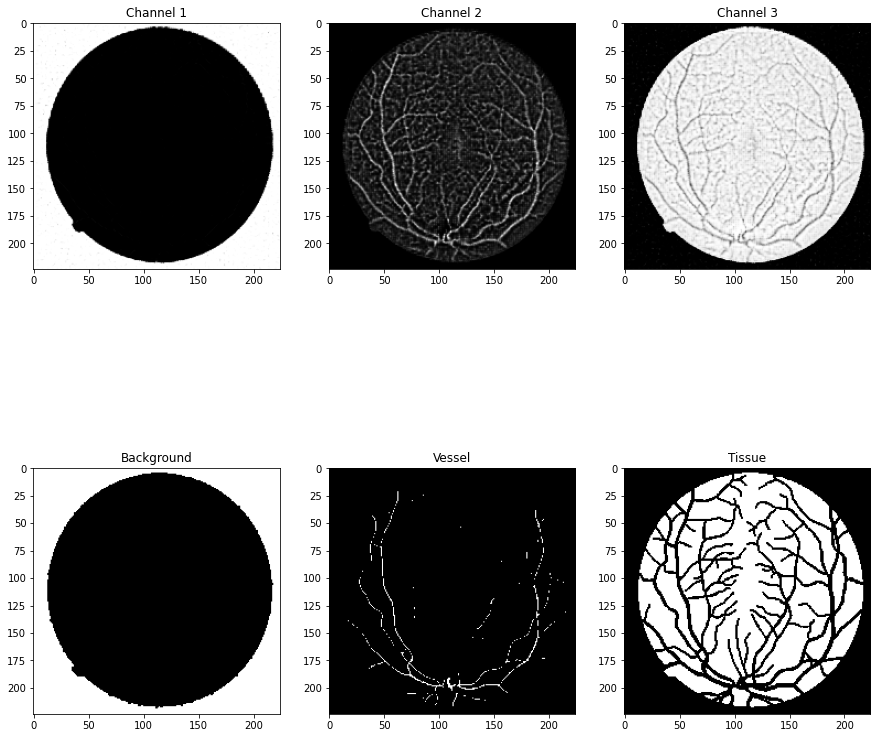

In [ ]:
# Visualizing segmentation on one of the test images
randIdx = np.random.randint(5)
img_no = randIdx
print(img_no)
testImg = TestImages[randIdx]
testLab = TestLabels[randIdx].numpy()

# Feed-forward
segImg = net(testImg.unsqueeze(0).to(device))
# Applying softmax to get class probabilities
segImg_np = F.softmax(segImg,dim=1).data.squeeze(0)
if use_gpu:
    segImg_np = segImg_np.cpu()
segImg_np = segImg_np.numpy()

# Displaying segmented output and ground truth
plt.figure(figsize=(15,15))
plt.subplot(231)
plt.imshow(segImg_np[0,:,:],cmap='gray')
plt.title('Channel 1')
plt.subplot(232)
plt.imshow(segImg_np[1,:,:],cmap='gray')
plt.title('Channel 2')
plt.subplot(233)
plt.imshow(segImg_np[2,:,:],cmap='gray')
plt.title('Channel 3')


bg = testLab==0
vessel = testLab==1
tissue = testLab==2
plt.subplot(234)
plt.imshow(bg,cmap='gray')
plt.title('Background')
plt.subplot(235)
plt.imshow(vessel,cmap='gray')
plt.title('Vessel')
plt.subplot(236)
plt.imshow(tissue,cmap='gray')
plt.title('Tissue')
plt.show()